# Optimization and export of the model

## Objective :
- Optimize and choose the most efficient model
- Find the optimal decision threshold
- Test the model with data created by us
- Export the model with pickle to build the application in VScode

In [1]:
# Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import scipy.stats as stats
from scipy.stats import chi2_contingency

from imblearn.over_sampling import SMOTE

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
import xgboost as xgb

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, randint

import warnings
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning

from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

import pickle

# Basic model initialized with balanced class weights

In [2]:
# Load the preprocessed DataFrame
df = pd.read_pickle('processed_data.pkl')

In [3]:
#Split data into X (features) and y (label)

X = df.drop(columns=['Offer Accepted', 'Customer Number'])
y = df['Offer Accepted'].apply(lambda x: 1 if x == 'Yes' else 0)

#Split data into train and test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize numerical variables
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

In [4]:
# Initialize the models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'Support Vector Machine': make_pipeline(StandardScaler(), SVC(random_state=0, probability=True, class_weight='balanced')),
    'LightGBM': lgb.LGBMClassifier(random_state=42, class_weight='balanced'),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train))
}

# Dictionary to store performance metrics
performance_summary = {
    'Model': [],
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'AUC': []
}

In [5]:
# Evaluation function

def evaluation(model):
    # Train the model
    result = model.fit(X_train, y_train)
    y_pred = result.predict(X_test)
    
    # Display model scores
    train_score = result.score(X_train, y_train)
    test_score = result.score(X_test, y_test)
    print("Train Score:", train_score)
    print("Test Score:", test_score)

    # Display confusion matrix and classification report
    conf_matrix = confusion_matrix(y_test, y_pred)
    print('Confusion Matrix:\n', conf_matrix)
    print('Classification Report:\n', classification_report(y_test, y_pred))

    # Compute learning curves with recall for the positive class (1)
    N, train_score, val_score = learning_curve(model, X_train, y_train, cv=4, scoring='recall', train_sizes=np.linspace(0.1, 1.0, 10))
    
    # Plot learning curve
    plt.figure(figsize=(8, 6))
    plt.plot(N, train_score.mean(axis=1), label='Train Recall')
    plt.plot(N, val_score.mean(axis=1), label='Validation Recall')
    plt.xlabel('Number of Training Samples')
    plt.ylabel('Recall')
    plt.title('Learning Curve')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Compute ROC AUC score and plot ROC curve
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.decision_function(X_test)
    
    roc_auc = roc_auc_score(y_test, y_prob)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model.__class__.__name__} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model.__class__.__name__}')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()
    
    # Calculate performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    
    # Add performance metrics to the summary
    performance_summary['Model'].append(model.__class__.__name__)
    performance_summary['Accuracy'].append(accuracy)
    performance_summary['Precision'].append(precision)
    performance_summary['Recall'].append(recall)
    performance_summary['F1 Score'].append(f1)
    performance_summary['AUC'].append(roc_auc)

Logistic Regression
Train Score: 0.5914464534075105
Test Score: 0.5862068965517241
Confusion Matrix:
 [[1983 1422]
 [  66  125]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.58      0.73      3405
           1       0.08      0.65      0.14       191

    accuracy                           0.59      3596
   macro avg       0.52      0.62      0.44      3596
weighted avg       0.92      0.59      0.70      3596



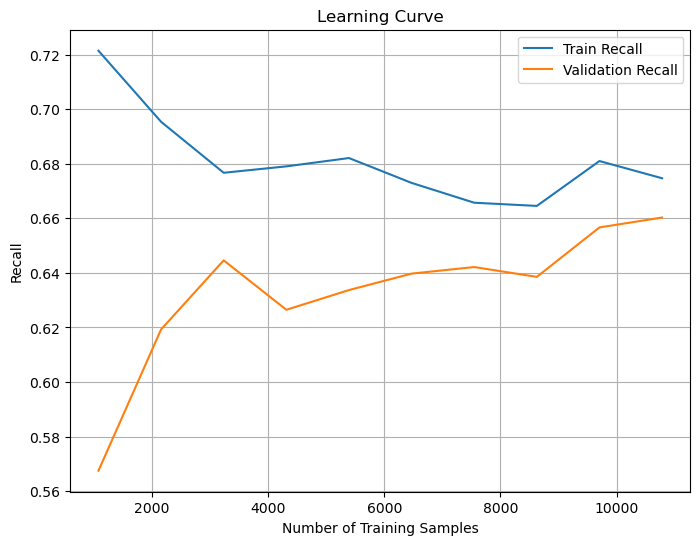

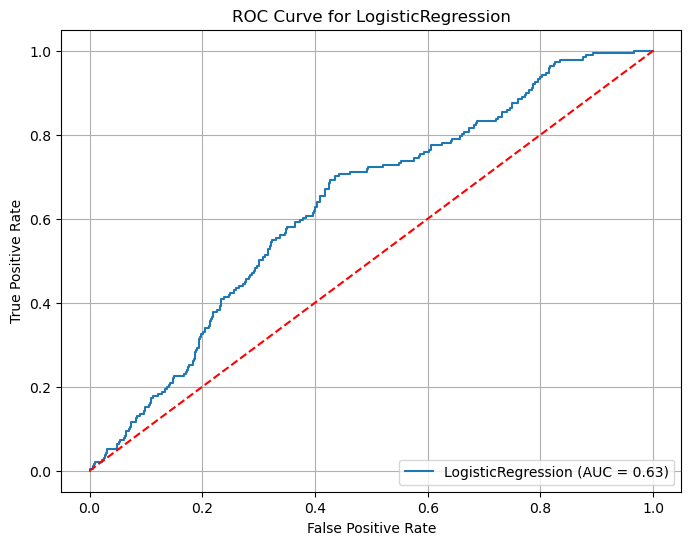

Support Vector Machine
Train Score: 0.7428372739916551
Test Score: 0.6952169076751946
Confusion Matrix:
 [[2383 1022]
 [  74  117]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.70      0.81      3405
           1       0.10      0.61      0.18       191

    accuracy                           0.70      3596
   macro avg       0.54      0.66      0.49      3596
weighted avg       0.92      0.70      0.78      3596



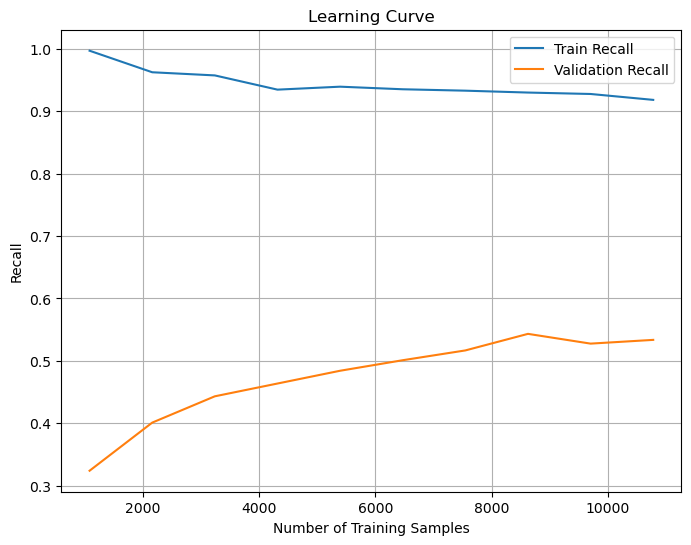

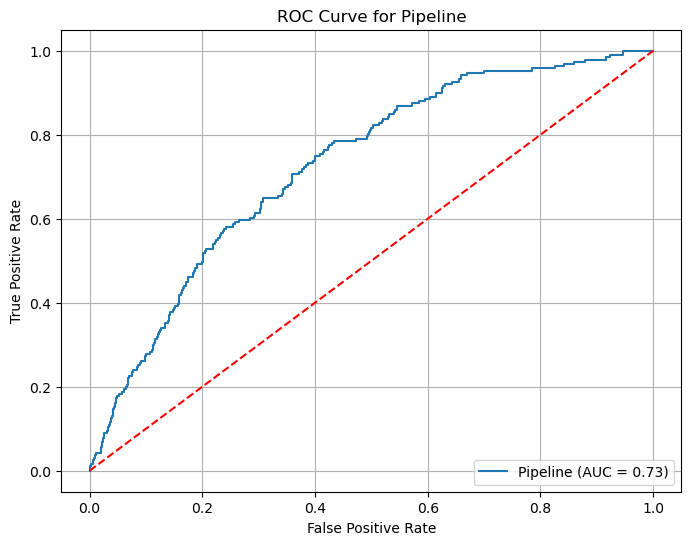

LightGBM
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 830, number of negative: 13550
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1311
[LightGBM] [Info] Number of data points in the train set: 14380, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Train Score: 0.8559805285118219
Test Score: 0.7958843159065628
Confusion Matrix:
 [[2770  635]
 [  99   92]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.81      0.88      3405
           1       0.13      0.48      0.20       191

    accuracy                           0.80      3596
   mac

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 269, number of negative: 4045
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Number of data points in the train set: 4314, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 330, number of negative: 5062
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1310
[LightGBM] [Info] Numb

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 569, number of negative: 9137
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1311
[LightGBM] [Info] Number of data points in the train set: 9706, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 622, number of negative: 10163
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=

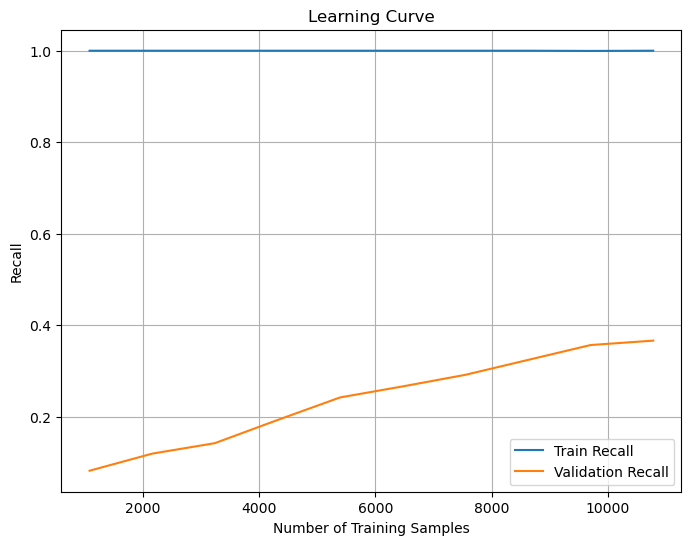

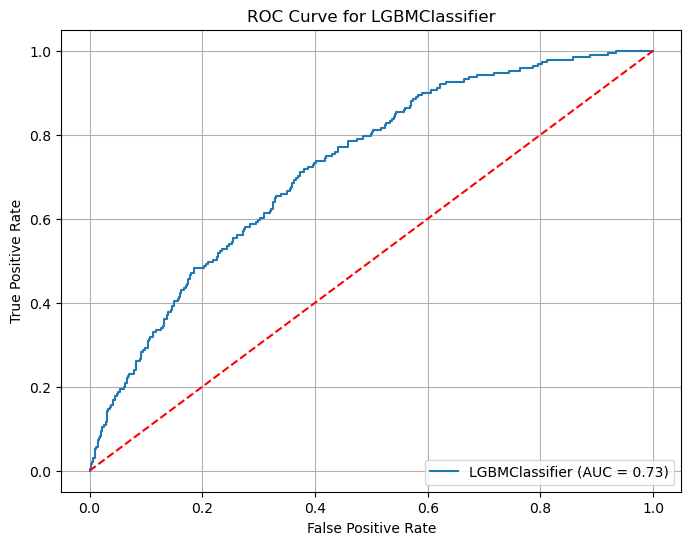

XGBoost
Train Score: 0.9648817802503477
Test Score: 0.8826473859844272
Confusion Matrix:
 [[3137  268]
 [ 154   37]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.92      0.94      3405
           1       0.12      0.19      0.15       191

    accuracy                           0.88      3596
   macro avg       0.54      0.56      0.54      3596
weighted avg       0.91      0.88      0.90      3596



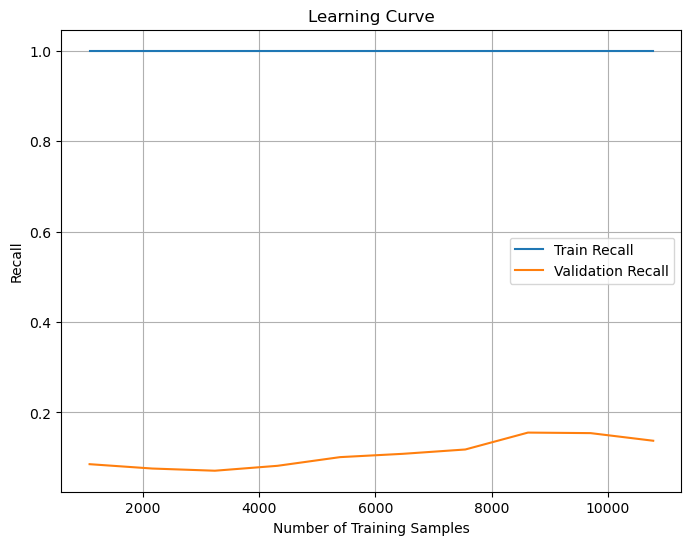

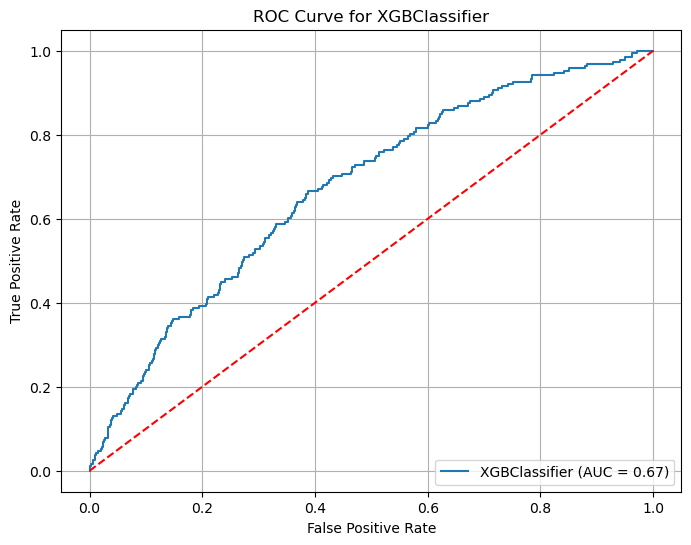

In [6]:
# Evaluate each model
for name, model in models.items():
    print(name)
    evaluation(model)

In [7]:
# Create a DataFrame with the results
performance_df = pd.DataFrame(performance_summary)

# Display the performance summary
print(performance_df)

                Model  Accuracy  Precision    Recall  F1 Score       AUC
0  LogisticRegression  0.586207   0.080802  0.654450  0.143843  0.633640
1            Pipeline  0.695217   0.102722  0.612565  0.175940  0.727183
2      LGBMClassifier  0.795884   0.126547  0.481675  0.200436  0.725046
3       XGBClassifier  0.882647   0.121311  0.193717  0.149194  0.673246


# Optimisation

In [8]:
from sklearn.feature_selection import SelectKBest, f_classif

In [9]:
def create_pipeline(model):
    return Pipeline([
        ('select_best', SelectKBest(score_func=f_classif, k=11)),
        ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
        ('classifier', model)
    ])

# Initialize the models with pipelines
models = {
    'Logistic Regression': create_pipeline(LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)),
    'Support Vector Machine': create_pipeline(SVC(class_weight='balanced', probability=True, random_state=42)),
    'LightGBM': create_pipeline(lgb.LGBMClassifier(random_state=42, class_weight='balanced')),
    'XGBoost': create_pipeline(xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train)))
}


Logistic Regression
Train Score: 0.6818497913769124
Test Score: 0.6760289210233593
Confusion Matrix:
 [[2295 1110]
 [  55  136]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.67      0.80      3405
           1       0.11      0.71      0.19       191

    accuracy                           0.68      3596
   macro avg       0.54      0.69      0.49      3596
weighted avg       0.93      0.68      0.77      3596



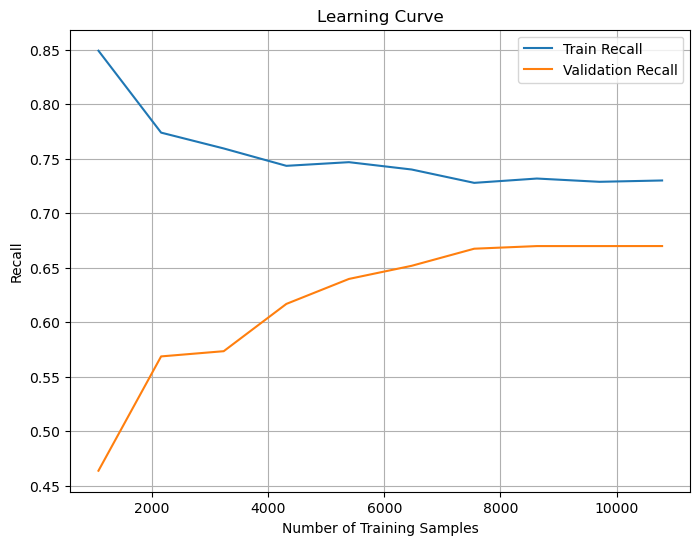

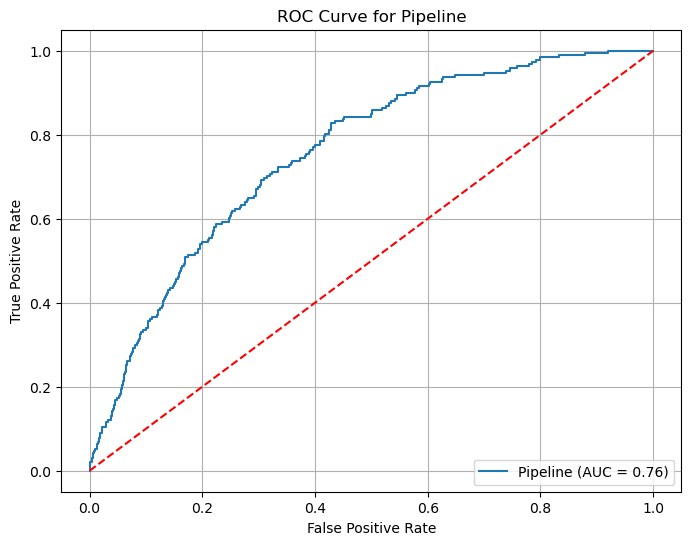

Support Vector Machine
Train Score: 0.7550764951321279
Test Score: 0.7224694104560623
Confusion Matrix:
 [[2483  922]
 [  76  115]]
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.73      0.83      3405
           1       0.11      0.60      0.19       191

    accuracy                           0.72      3596
   macro avg       0.54      0.67      0.51      3596
weighted avg       0.92      0.72      0.80      3596



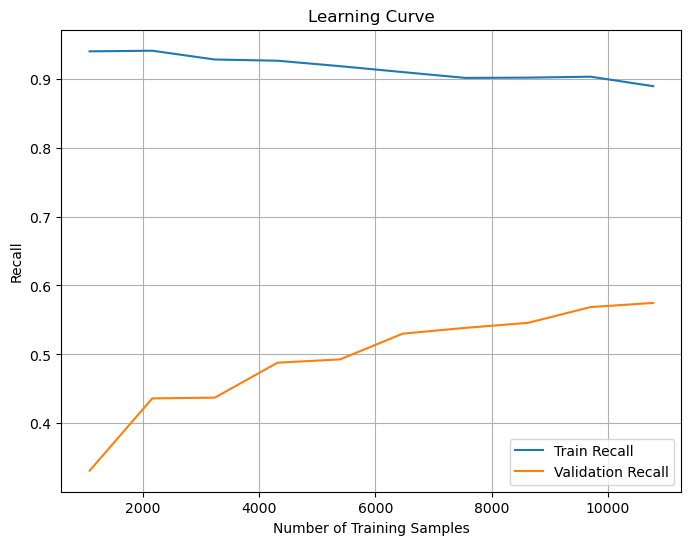

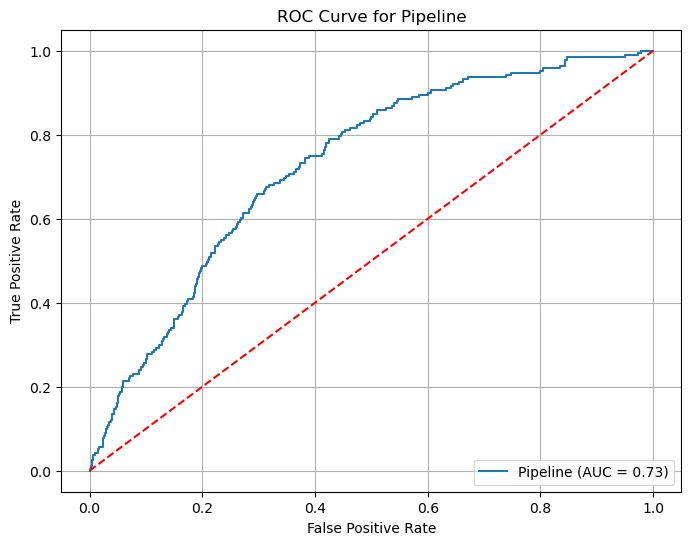

LightGBM
[LightGBM] [Info] Number of positive: 830, number of negative: 13550
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005111 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8684
[LightGBM] [Info] Number of data points in the train set: 14380, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
Train Score: 0.9027816411682893
Test Score: 0.8225806451612904
Confusion Matrix:
 [[2891  514]
 [ 124   67]]
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.85      0.90      3405
           1       0.12      0.35      0.17       191

    accuracy                           0.82      3596
   macro avg       0.54      0.60      0.54      3596
weighted avg       0.91      0.82      0.86      3596

[LightGBM] [Info] Number of positive: 78,

[LightGBM] [Info] Number of positive: 383, number of negative: 6088
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6208
[LightGBM] [Info] Number of data points in the train set: 6471, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 450, number of negative: 7099
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8662
[LightGBM] [Info] Number of data points in the train set: 7549, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM]

[LightGBM] [Info] Number of positive: 206, number of negative: 3029
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8678
[LightGBM] [Info] Number of data points in the train set: 3235, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] Number of positive: 265, number of negative: 4049
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 10943
[LightGBM] [Info] Number of data points in the train set: 4314, number of used features: 77
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Info] N

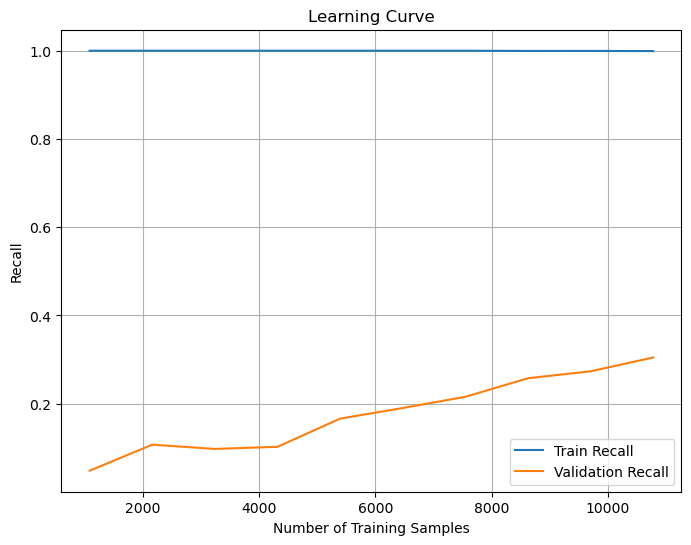

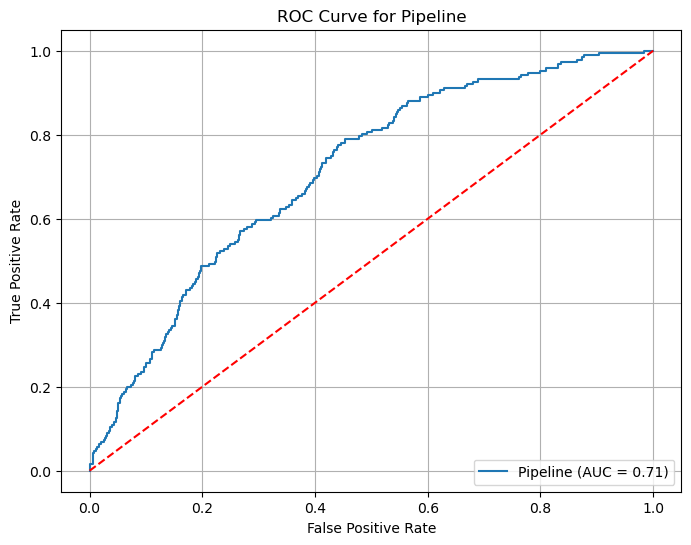

XGBoost
Train Score: 0.9801112656467316
Test Score: 0.9010011123470523
Confusion Matrix:
 [[3214  191]
 [ 165   26]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.94      0.95      3405
           1       0.12      0.14      0.13       191

    accuracy                           0.90      3596
   macro avg       0.54      0.54      0.54      3596
weighted avg       0.91      0.90      0.90      3596



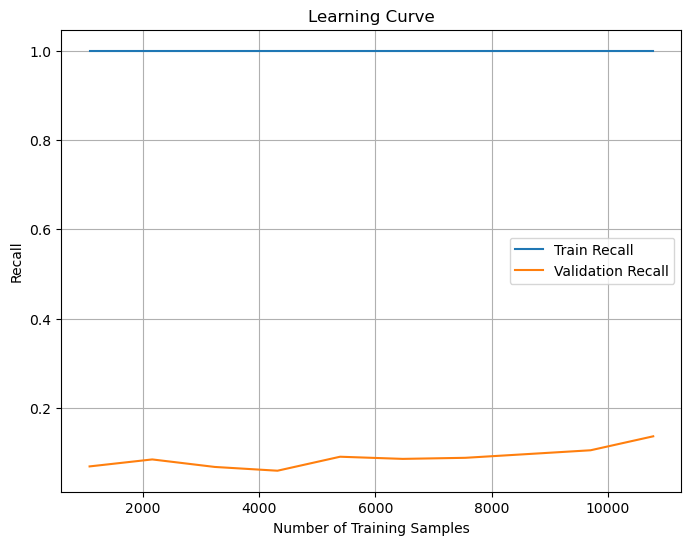

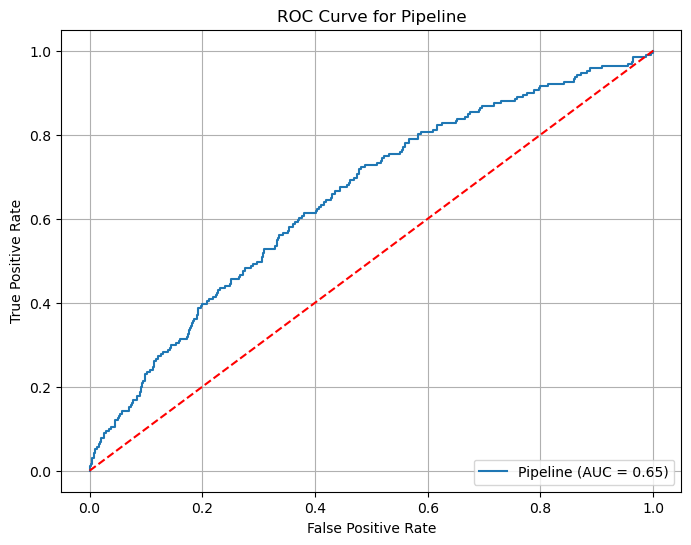

In [10]:
# Evaluate each model
for name, model in models.items():
    print(name)
    evaluation(model)

In [11]:
# Create a DataFrame with the results
performance_df = pd.DataFrame(performance_summary)

# Display the performance summary
print(performance_df)

                Model  Accuracy  Precision    Recall  F1 Score       AUC
0  LogisticRegression  0.586207   0.080802  0.654450  0.143843  0.633640
1            Pipeline  0.695217   0.102722  0.612565  0.175940  0.727183
2      LGBMClassifier  0.795884   0.126547  0.481675  0.200436  0.725046
3       XGBClassifier  0.882647   0.121311  0.193717  0.149194  0.673246
4            Pipeline  0.676029   0.109149  0.712042  0.189283  0.755560
5            Pipeline  0.722469   0.110897  0.602094  0.187296  0.728136
6            Pipeline  0.822581   0.115318  0.350785  0.173575  0.711029
7            Pipeline  0.901001   0.119816  0.136126  0.127451  0.650283


In [12]:
create_pipeline(LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))

Pipeline(steps=[('select_best', SelectKBest(k=11)),
                ('poly_features', PolynomialFeatures(include_bias=False)),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [13]:
def create_pipeline(model):
    return Pipeline([
        ('select_best', SelectKBest(score_func=f_classif, k=11)),
        ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),
        ('classifier', model)
    ])

# Define a reduced parameter distribution
param_dist = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga']
}

# Create the pipeline with logistic regression
pipeline = create_pipeline(LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=1000,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    random_state=42,
    verbose=2
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get the best model from RandomizedSearchCV
best_model = random_search.best_estimator_

# Print best parameters and recall score
print("Best parameters found: ", random_search.best_params_)
print("Best recall score: ", random_search.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 20 is smaller than n_iter=1000. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters found:  {'classifier__solver': 'liblinear', 'classifier__penalty': 'l1', 'classifier__C': 0.01}
Best recall score:  0.6987951807228916


Train Score: 0.6384561891515994
Test Score: 0.6390433815350389
Confusion Matrix:
 [[2158 1247]
 [  51  140]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.63      0.77      3405
           1       0.10      0.73      0.18       191

    accuracy                           0.64      3596
   macro avg       0.54      0.68      0.47      3596
weighted avg       0.93      0.64      0.74      3596



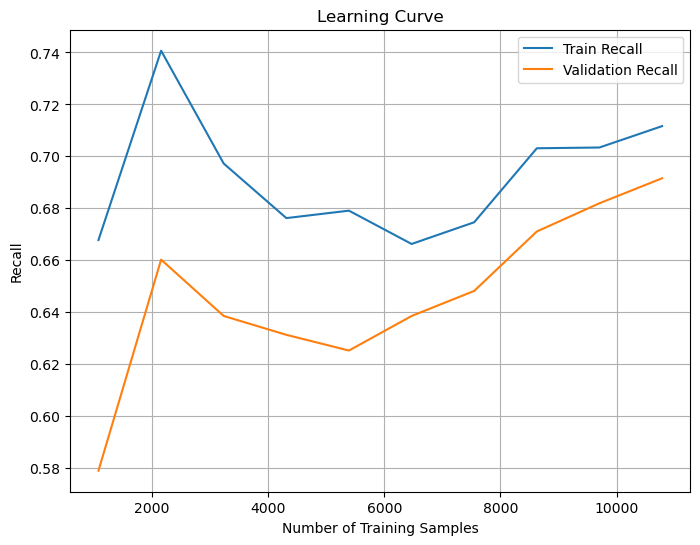

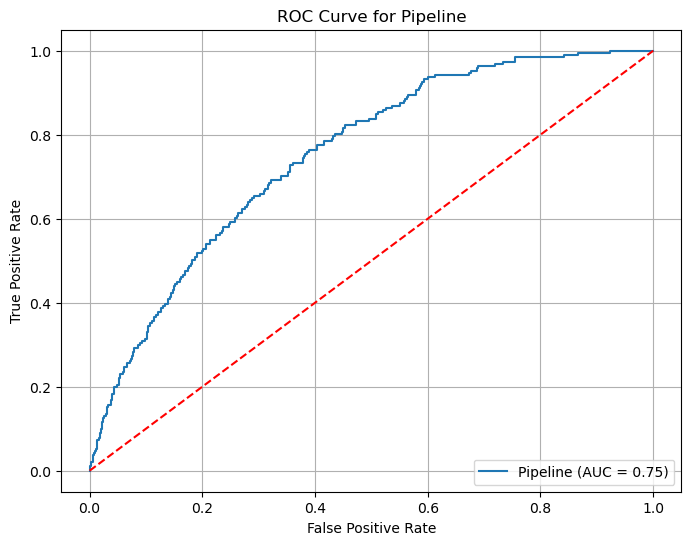

In [14]:
# Evaluate the best model
evaluation(best_model)

In [15]:
def create_pipeline(model):
    return Pipeline([
        ('select_best', SelectKBest(score_func=f_classif, k=11)),  # Reduce the number of selected features
        ('poly_features', PolynomialFeatures(degree=2, include_bias=False)),  # Reduce the degree
        ('classifier', model)
    ])

# Define a simplified parameter grid
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'classifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'classifier__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'classifier__l1_ratio': [0, 0.25, 0.5, 0.75, 1]  # This is only used if penalty is 'elasticnet'
}

# Create the pipeline with logistic regression
pipeline = create_pipeline(LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000))

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='recall',  # You can change to 'recall' if it is more relevant to your case
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_

# Print best parameters and recall score
print("Best parameters found: ", grid_search.best_params_)
print("Best recall score: ", grid_search.best_score_)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
1500 fits failed out of a total of 2500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
125 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 475, in fit
    self._final_estimato

Best parameters found:  {'classifier__C': 0.01, 'classifier__l1_ratio': 0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best recall score:  0.6987951807228916


C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Train Score: 0.6384561891515994
Test Score: 0.6390433815350389
Confusion Matrix:
 [[2158 1247]
 [  51  140]]
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.63      0.77      3405
           1       0.10      0.73      0.18       191

    accuracy                           0.64      3596
   macro avg       0.54      0.68      0.47      3596
weighted avg       0.93      0.64      0.74      3596



C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
C:\Users\Admin\anaconda3\Lib\site-packag

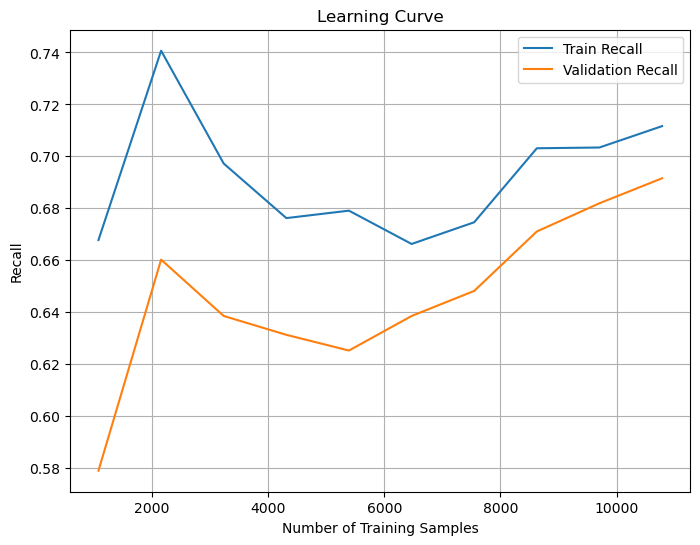

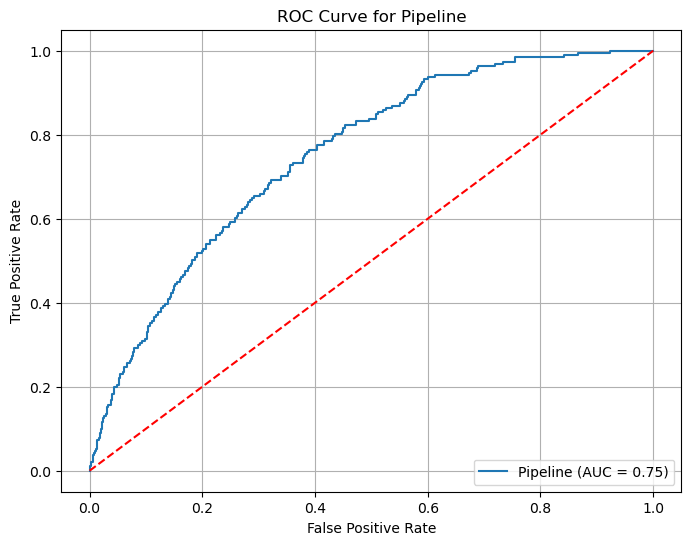

In [16]:
# Evaluate the best model
evaluation(best_model)

### Let's find the optimal threshold to decide

AUC:  0.7521568989244335
Optimal Threshold (ROC):  0.48438422223427274


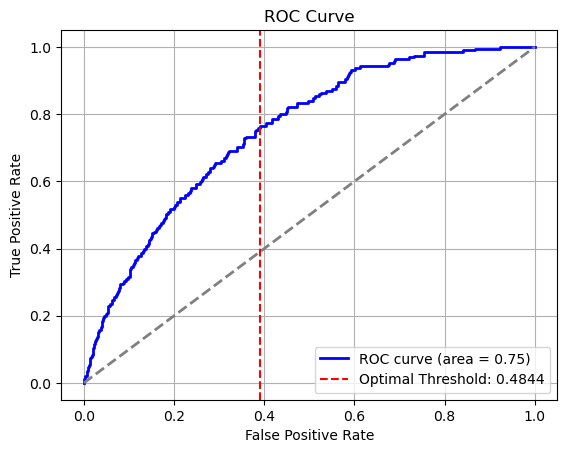

Confusion Matrix (ROC):
[[2079 1326]
 [  45  146]]
Classification Report (ROC):
              precision    recall  f1-score   support

           0       0.98      0.61      0.75      3405
           1       0.10      0.76      0.18       191

    accuracy                           0.62      3596
   macro avg       0.54      0.69      0.46      3596
weighted avg       0.93      0.62      0.72      3596



In [36]:
# Function to find the optimal threshold using the ROC curve
def decision_function_roc(y_test, y_scores):
    # Compute the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = roc_auc_score(y_test, y_scores)
    print("AUC: ", roc_auc)
    
    # Find the optimal threshold (e.g., the point closest to the upper left corner)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    print("Optimal Threshold (ROC): ", optimal_threshold)
    
    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.axvline(x=fpr[optimal_idx], color='red', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.4f}')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return optimal_threshold

# Get the predicted probabilities
y_test_scores = best_model.predict_proba(X_test)[:, 1]

# Get optimal threshold using the ROC method
optimal_threshold_roc = decision_function_roc(y_test, y_test_scores)

# Make predictions on the test set using the optimal threshold
y_test_pred_optimal_roc = decision_function(y_test_scores, optimal_threshold_roc)

# Evaluate the new predictions
print('Confusion Matrix (ROC):')
print(confusion_matrix(y_test, y_test_pred_optimal_roc))
print('Classification Report (ROC):')
print(classification_report(y_test, y_test_pred_optimal_roc))


# New Input

In [37]:
#

X= np.array([['Air Miles', 'Letter', 'High', 2, 'Yes',
             'High', 2, 1, 5, 'No',
             1100.75, 1600.0, 800.0, 1000.0,1002.0]])
X

array([['Air Miles', 'Letter', 'High', '2', 'Yes', 'High', '2', '1', '5',
        'No', '1100.75', '1600.0', '800.0', '1000.0', '1002.0']],
      dtype='<U32')

In [39]:
le_reward = LabelEncoder()
le_mailerType = LabelEncoder()
le_incomeLevel = LabelEncoder()
le_overdraftProtection = LabelEncoder()
le_creditRating = LabelEncoder()
le_homeOwner = LabelEncoder()

In [40]:
#Apply label encoder on 

X[:, 0] = le_reward.fit_transform(X[:, 0])
X[:, 1] = le_mailerType.fit_transform(X[:, 1])
X[:, 2] = le_incomeLevel.fit_transform(X[:, 2])
X[:, 4] = le_overdraftProtection.fit_transform(X[:, 4])
X[:, 5] = le_creditRating.fit_transform(X[:, 5])
X[:, 9] = le_homeOwner.fit_transform(X[:, 9])
X = X.astype(float)
X

array([[0.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00, 0.00000e+00,
        0.00000e+00, 2.00000e+00, 1.00000e+00, 5.00000e+00, 0.00000e+00,
        1.10075e+03, 1.60000e+03, 8.00000e+02, 1.00000e+03, 1.00200e+03]])

In [41]:
# Make predictions on the test set using the optimal threshold
y_test_scores = best_model.predict_proba(X)[:, 1]
y_test_pred_optimal = decision_function(y_test_scores, optimal_threshold)
y_test_pred_optimal

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(


array([0])

# Export Model

In [42]:
data = {'model': best_model,
       'le_reward': le_reward,
       'le_mailerType': le_mailerType,
       'le_incomeLevel': le_incomeLevel,
       'le_overdraftProtection': le_overdraftProtection,
       'le_creditRating': le_creditRating,
       'le_homeOwner': le_homeOwner}
with open('model.pkl', 'wb') as file:
    pickle.dump(data, file)

In [43]:
#Test if prediction works with saved data

with open('model.pkl', 'rb') as file:
    data = pickle.load(file)
    
best_model_loaded = data['model']
le_reward = data['le_reward']
le_mailerType = data['le_mailerType']
le_incomeLevel = data['le_incomeLevel']
le_overdraftProtection = data['le_overdraftProtection']
le_creditRating = data['le_creditRating']
le_homeOwner = data['le_homeOwner']

In [44]:
# Run prediction from loaded model

y_test_scores = best_model_loaded.predict_proba(X)[:, 1]
y_test_pred_optimal = decision_function(y_test_scores, optimal_threshold)
y_test_pred_optimal

C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SelectKBest was fitted with feature names
  warnings.warn(


array([0])